# Program to read Wave HVA file and produce WSE's
### JW 12/18-01/19

In [1]:
import math
import sys
import binascii
import statistics as s
import matplotlib.pyplot as plt
import scipy as sp
import numpy as np
import pylab

from statistics import mean
from scipy.signal import tukey
from scipy import fftpack
from mpl_toolkits.mplot3d import Axes3D
from datetime import datetime, time, timedelta
###from pathlib import Path, PureWindowsPath

from tkinter import filedialog
from tkinter import *
from itertools import count # izip for maximum efficiency

In [2]:
def Do_CRC(packet):
# Do CRC-4 checksum calculation
# See DWTP 2.1.1 pp25-26.
    key_table = [0,3,6,5,12,15,10,9,11,8,13,14,7,4,1,2]; crc = 0
    for i in range(len(packet)):
        crc = key_table[(crc^(int(packet[i][0],16))) & int('0x0f',16)]        # First nibble
        if (i > 0): 
            crc = key_table[(crc^int(packet[i][1],16)) & int('0x0f',16)]      # Second nibble

    crc = (crc^int(packet[0][1],16)) & int('0x0f',16)
    if (crc != 0): 
        print('CRC Error!',crc)
    return

In [3]:
def Displacement(valu):
# Decode real time data to Displacements_List in metres
# See DWTP 2.1.1 p20. Formula 16
    return (0.457*math.sinh(valu/457.))

In [4]:
def dd2dms(deg):
    d = int(deg)
    md = abs(deg - d) * 60
    m = int(md)
    sd = str((md - m) * 60)
    deg = str(d)+chr(176)
    dms = deg+' '+str(m)+"' "+sd[:7]+'"'
    return (dms)

In [5]:
def Do_Timestamp(packet):
# Decode SST message vide DWTP p. 27
    Do_CRC(packet)
    Datawell_start_time = datetime(1970,1,1)
    i = int(packet[2]+packet[3]+packet[4]+packet[5],16)

    if i == 2**32-1:                   # Check for NaN
        print("Timestamp = NaN")
        Record_time = datetime.date.min
    else:
        Record_time = Datawell_start_time + timedelta(seconds=i) 
        + timedelta(hours=10)  # Corrected from UTC to Aus EST  
    return (Record_time,i)

In [6]:
def twos_complement(value, bitWidth):
    if value >= 2**bitWidth:
        # This catches value that is out of range
        raise ValueError("Value: {} out of range of {}-bit value.".format(value, bitWidth))
    else:
        return value - int((value << 1) & 2**bitWidth)

In [7]:
def Do_F20(packet):
# Decode Heave spectrum message vide DWTP p. 38-40
##    print('In Heave spectrum routine')
    import math
    Do_CRC(packet)
    Record_time = Do_Timestamp(packet)
    Data_stamp = packet[6]+packet[7]
    No_of_segments = int(packet[8],16)
    if No_of_segments == 255:                   # Check for NaN
        print("Number of segments = NaN")
    Smax = int(packet[9]+packet[10][0],16)
    if Smax == 4095:                   # Check for NaN
        print("Smax = NaN"); Smax = -99.99
    else:
        Smax = 5000*(math.exp(Smax/200.) - 1) / (math.exp(4094/200.) - 1)
    s_tilde = []
    for i in range(0,148,3):
        u = int(packet[11+i]+packet[12+i][0],16)
        s_tilde.append(Smax*(math.exp(u/200.) - 1) / (math.exp(4094/200.) - 1))
        u = int(packet[12+i][1]+packet[13+i],16)
        s_tilde.append(Smax*(math.exp(u/200.) - 1) / (math.exp(4094/200.) - 1))
    
###    print('{:18s}{:%Y-%m-%d %H:%M}{:6s}'.format('Heave spectrum at ',Record_time,' AEST:'))
###    print('{:27s}{:10.4f}{:2s}{:1s}{:3s}'.format('Peak value of PSD (Smax) = ',Smax,' m',chr(178),'/Hz'))
###    for i in range(0,len(s_tilde)-9,10):
###        print('{:10.6f}{:10.6f}{:10.6f}{:10.6f}{:10.6f}{:10.6f}{:10.6f}{:10.6f}{:10.6f}{:10.6f}'\
###        .format(s_tilde[i],s_tilde[i+1],s_tilde[i+2],s_tilde[i+3],s_tilde[i+4],s_tilde[i+5],\
###        s_tilde[i+6],s_tilde[i+7],s_tilde[i+8],s_tilde[i+9]))
    
    return (Record_time,s_tilde)

In [8]:
def Do_F23(packet,Old_time,Flag):
# Decode Spectrum synchronisation message vide DWTP p. 45-47
##    print('In Spectrum synchronisation routine')
    Do_CRC(packet)
    Record_time = Do_Timestamp(packet)
    Data_stamp = packet[6]+packet[7]
    Segments_used = '0000000'+packet[8][:-1]+packet[9]+packet[10]
    Sample_number = packet[11]+packet[12]
            
    Hn_1 = packet[13]+packet[14][0]; Nn_1 = packet[14][1]+packet[15]; Wn_1 = packet[16]+packet[17][0]
    Hn = packet[17][1]+packet[18]; Nn = packet[19]+packet[20][0]; Wn = packet[20][1]+packet[21]
    
    Match_vector = Hn_1+Nn_1+Wn_1+Hn+Nn+Wn  # build a HEX string to be matched with WLS list

    Hn_1_sign = Displacement(twos_complement(int(Hn_1,16),12))        # Uses formula 16 from DWTP p. 20
    Nn_1_sign = Displacement(twos_complement(int(Nn_1,16),12))
    Wn_1_sign = Displacement(twos_complement(int(Wn_1,16),12))

    Hn_sign = Displacement(twos_complement(int(Hn,16),12))
    Nn_sign = Displacement(twos_complement(int(Nn,16),12))
    Wn_sign = Displacement(twos_complement(int(Wn,16),12))
    
    if Sample_number == 65536:                   # Check for NaN
        print("Timestamp = NaN")
    else:
        if Record_time == Old_time:      # Need to check for repeats 
            Old_time = Record_time+timedelta(minutes=30); Flag = True
###            print('{:28s}{:%Y-%m-%d %H:%M}{:5s}'.format('Spectrum synchronisation at ',Record_time,' AEST'))
###            print('{:16s}{:s}'.format('Segments used = ',Segments_used))
###            print('{:30s}{:5d}'.format('Number of samples in record = ',int(Sample_number,16)))
###            print('{:27s}{:5.2f}{:21s}{:5.2f}'.format('Second last displacement = ', Hn_1_sign,' Last displacement = ',Hn_sign))
###            print('{:27s}{:5.2f}{:21s}{:5.2f}'.format('Second last North        = ', Nn_1_sign,' Last North        = ',Nn_sign))
###            print('{:27s}{:5.2f}{:21s}{:5.2f}'.format('Second last West         = ', Wn_1_sign,' Last West         = ',Wn_sign))
    
    Time_stamp = Record_time  # Time_stamp will be the time of the heave matched in WLS list
    return (Time_stamp, Match_vector,Old_time,Flag)

In [9]:
def Get_Displacements(Position, Status, Displacements_List, wls, north, west):    
# In the Mk4, the data is sampled over a 30-minute period using a 2.56Hz sampling frequency.
# This results in 1800 x 2.56 = 4608 samples per half-hour.
    for m in range(2304):            # Each real-time vector consists of TWO sets of Heave, North, West values!
        try:
            n = Position[0]+1+m          # need to move one cell past this position (as it is the end of the previous records)

#######################################
# Read displacement data and convert to actual values
# Refer to DWTP pp.19-21 AND Datawell Waverider RX-C4 Receiver Manual p.38
#######################################
##        line_number = Cycle_counter[m]
            displacement_record = Displacements_List[n]
            status_byte = displacement_record[0:1]
            Status.append(status_byte)
            record_0 = displacement_record[1:3]
            record_1 = displacement_record[3:5]
            record_2 = displacement_record[5:7]
            record_3 = displacement_record[7:9]
            record_4 = displacement_record[9:11]
            record_5 = displacement_record[11:13]
            record_6 = displacement_record[13:15]
            record_7 = displacement_record[15:17]
            record_8 = displacement_record[17:19]
        
# Build the 12 bit HEX value from the 8 bit records 0 to 8        
            h0 = record_0+record_1[0]; n0 = record_1[1]+record_2; w0 = record_3+record_4[0]
            h1 = record_4[1]+ record_5; n1 = record_6+record_7[0]; w1= record_7[1]+record_8
        
### Need to include check for NAN here !!!

# Convert the 12 bit HEX value into a signed integer, and then into actual displacement value
            h0_sign = Displacement(twos_complement(int(h0,16),12))
            n0_sign = Displacement(twos_complement(int(n0,16),12))
            w0_sign = Displacement(twos_complement(int(w0,16),12))
            h1_sign = Displacement(twos_complement(int(h1,16),12))
            n1_sign = Displacement(twos_complement(int(n1,16),12))
            w1_sign = Displacement(twos_complement(int(w1,16),12))
        
# Build lists holding each of the displacement values
            wls.append(h0_sign); wls.append(h1_sign) 
            north.append(n0_sign); north.append(n1_sign)
            west.append(w0_sign); west.append(w1_sign)
        except IndexError as e:
            print(e)
            sys.exit()   # Trap EoF exception

    return()

In [10]:
################################################################################################
def Do_spectral_plot(f_avg,Pden_avg,f2,Pden2,Record_time):
###def Do_spectral_plot(f_Mk4,Pden_Mk4,f_avg,Pden_avg,f2,Pden2,Record_time,Buoy_time):
# Do Spectral plot
    plt.figure(figsize=(20,10))
    plt.tick_params(axis='both', which='major', labelsize=15)
### max_Pdens = max(max(Pden_Mk4),max(Pden_avg),max(Pden2))
    max_Pdens = max(max(Pden_avg),max(Pden2))
    plt.xticks(np.arange(0,1.2, 0.1))
    plt.grid(True)
    plt.title(Record_time)
 
###    pylab.plot(f_Mk4, Pden_Mk4, '-r', label='Mk4 spectra')
    pylab.plot(f_avg, Pden_avg, '-b', label='Banded avarage')
    pylab.plot(f2, Pden2, '-g', label="Welch's method")
    pylab.legend(loc='upper right')
    pylab.ylim(0,max_Pdens)
    pylab.show()
    
    return()
###############################

Reading  C:/QGHL/Wave_data/Bris/brisbane_4183}2018-12-09T00h00Z.hva
Closing  C:/QGHL/Wave_data/Bris/brisbane_4183}2018-12-09T00h00Z.hva
(datetime.datetime(2018, 12, 8, 23, 30), 1544311800) 2018-12-09 00:00:00 0.11 9.090909090909092 0.11 9.090909090909092


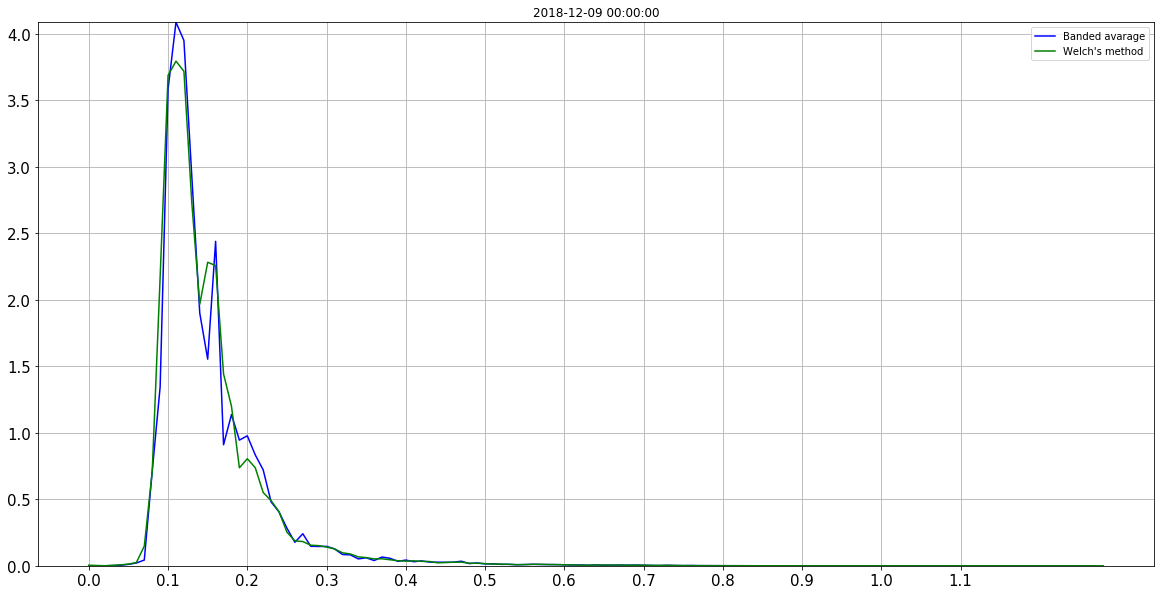

Enter key (or x to Exit) > x


In [27]:
#######################################
# HVA file format:
# NN,SRRRRRRRRRRRRRRRRRR,SPPPPPP<CR>
# 28,-03B0B8158F3501612B,-81C79E
#######################################
# Select input file - code from https://pythonspot.com/tk-file-dialogs/
root = Tk() 
root.filename =  filedialog.askopenfilename(initialdir = "/",title = "Select HVA file",filetypes = (("HVA files","*.HVA"),("all files","*.*")))
root.destroy()
Input_HVA_File = root.filename

date_str = Input_HVA_File.split('}')[1].split('.')[0]
Start_time = datetime.strptime(date_str, "%Y-%m-%dT%Hh%MZ")
Old_time = Start_time
#######################################

Sample_frequency = 2.56                 # vide Datawell Library Manual P.40
dt = 1./Sample_frequency                # i.e. ~0.39s
Samples_per_segment = 512               # vide Datawell Library Manual P.40
record_length = 4608                    # Number of points in Mk4 record
npts = 4608                             # Number of points in sample record for calc. spectra via Welch's method
###npts = 4096                             # Number of points in sample record for calc. spectra via Cooley-Tukey fast Fourier transform
Cycle_counter = []; Displacements_List = []; Packet_List = []

# Open file and read data into separate lists
file = open(Input_HVA_File,"r")
print('Reading ',Input_HVA_File)
for line in file:
    fields = line.split(",")
    Cycle_counter.append(fields[0]); Displacements_List.append(fields[1]); Packet_List.append(fields[2])
file.close()
print('Closing ',Input_HVA_File)

# Read packet data and convert to actual values
##Length = len(Packet_List)-1
Length = len(Packet_List)
Packet_data = []
for i in range(len(Packet_List)-1):
    Packet_data.append(Packet_List[i][1:3])
    Packet_data.append(Packet_List[i][3:5])
    Packet_data.append(Packet_List[i][5:7])
    
# Find all instances where 0x7E exists - see DWTP p.21 Section 2.1.2 Decoding the packet data to messages
Valu_0x7E_List = [i for i, j in enumerate(Packet_data) if j == '7E']

Flag = True   # Used to identify first occurrence of repeated data in the messages
fk = []; s_tilde = []; dirn = []; spread = []
# Get the bytes between respective '0x7E' values - ignoring where consecutive '7E' values exist
for i in range(len(Valu_0x7E_List)-1):
    start = Valu_0x7E_List[i]+1; end = Valu_0x7E_List[i+1] # a packet message contained between two occurrences of 0x7E
    if end-start > 1:
        Decoded = Packet_data[start:end]
        
        Found_7D = [m for m, n in enumerate(Decoded) if n == '7D']     # Locate '7D' in packet

        for p in range(len(Found_7D)):
            XOred = hex(int(Decoded[Found_7D[p]+1],16)^int('20',16))   # X'Or the byte after '7D'
            Decoded[Found_7D[p]+1] = XOred[2:].upper()
        for p in range(len(Found_7D)-1,-1,-1): 
            del Decoded[Found_7D[p]]                                   # Remove this '7D' from the packet
            
        Message_Id = Decoded[0][0]+Decoded[1]; CRC_4_Checksum = Decoded[0][1]
        
        if (Message_Id == 'F20'): Buoy_time,Pden_Mk4 = Do_F20(Decoded) # Get spectra as calculated onboard Mk4 buoy
            
        if (Message_Id == 'F23'): # NOTE 0xF23 is the Spectrum synchronisation message - See DWTP pp.45-47!
            Time_stamp,Match_vector,Old_time,Flag = Do_F23(Decoded,Old_time,Flag)          # Decode Spectrum synchronisation message
            Position = [i for i, j in zip(count(), Displacements_List) if j == '-'+Match_vector] # Locate the time stamp in the real time data
            if len(Position) > 0: # If a match is found in the real time data
                Status = []; wls = []; north = []; west = []; wls_burst = []
                Get_Displacements(Position, Status, Displacements_List, wls, north, west)  # Get the WL's, and Displacements in North and West
                Record_time = Time_stamp[0] + timedelta(seconds=record_length/Sample_frequency) # Need to advance by 30 mins for start of next real time data 1Grecord
                if Flag: # denotes first occurrence of repeat data - so, display it
###                    Print_wls_north_west(record_length,Record_time,wls,north,west)
                    x=list(range(npts)); x = [y * dt for y in x]
#######################################
                    f_avg = []; Pden_avg = []; f_Mk4 = []
                    for i in range(0,46,1): f_Mk4.append(0.025+0.005*i)
                    for i in range(46,79,1): f_Mk4.append(-0.20+0.010*i)
                    for i in range(79,100,1): f_Mk4.append(-0.98+0.020*i)
                    
                    f1, Pden1 = sp.signal.periodogram(wls[0:4096],Sample_frequency,scaling='density',window=tukey(4096))
                    f2, Pden2 = sp.signal.welch(wls,fs=Sample_frequency,window='hanning',nperseg=256,noverlap=128,\
                        nfft=None,detrend='constant',return_onesided=True,scaling='density',axis=-1)
                    
                    f_avg.append(0); Pden_avg.append(mean(Pden1[0:9]))
                    for i in range(1,128,1): 
                        f_avg.append(f1[i*16]); Pden_avg.append(mean(Pden1[i*16-8:i*16+8]))
# Peak frequency and period of banded spectra (Fp)                
                    Fp1 = f_avg[Pden_avg.index(max(Pden_avg))]; Tp1 = 1/Fp1
                    Fp2 = f2[Pden2.argmax()]; Tp2 = 1/Fp2
                    print(Buoy_time,Record_time,Fp1,Tp1,Fp2,Tp2);
###                    Do_time_series_plot(wls,wls_mean,Zero_Upcross,UpCrossing,Zero_Downcross,DownCrossing,Wave_crest,Crests,Wave_trough,Troughs)
###                    Do_spectral_plot(f_Mk4,Pden_Mk4,f_avg,Pden_avg,f2,Pden2,Buoy_time,Record_time)
                    Do_spectral_plot(f_avg,Pden_avg,f2,Pden2,Record_time)
#######################################                    
                    Flag = False  # drop flag to ignore repeat data


                    choice = input("Enter key (or x to Exit) > ")
                    if choice == 'x' : break


In [26]:
Time_stamp[0] + timedelta(seconds=record_length/Sample_frequency)

datetime.datetime(2018, 12, 8, 0, 0)

In [22]:
Time_stamp

(datetime.datetime(2018, 12, 7, 23, 30), 1544225400)